<a href="https://colab.research.google.com/github/Aneesha-Shr/Fiber-Image-Tracking/blob/main/Fiber_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Oct 15 19:29:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything-2.git

  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-7q47tawx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-7q47tawx
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.5 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=501909 sha256=e13975ee705d83ae147f2e0ababb42956711ca314c994744f558f15816a120ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-0bl29f0z/wheels/b0/5b/a1/c16dafb8c3c0046f1158e7fa7570559a72085df5beab759ba0
  Created wheel

In [ ]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.6 MB/s eta 0:00:00


In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from torchvision import transforms
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor
#from sam2.build_sam import build_sam2
#from sam2.sam2_video_predictor import SAM2VideoPredictor
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

Function to prepare Folder of Images(Input) into a Video Tensor(Pseudo video)

In [ ]:
def gen_Video_Tensor(path):
  transform = transforms.Compose([transforms.ToTensor(),])
  pseudoFrames = []
  for filename in sorted(os.listdir(path)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.tif')):
      imagePath = os.path.join(path, filename)
      image = Image.open(imagePath).convert("RGB")
      tensor = transform(image)
      pseudoFrames.append(tensor)
  pseudoVideo = torch.stack(pseudoFrames)
  return pseudoVideo

Function to turn folder of TIFF into folder of JPEG

In [ ]:
def tiff_To_jpeg(input, output):
  if not os.path.exists(output):
    os.makedirs(output)
  for filename in os.listdir(input):
    if filename.lower().endswith(('.tif', '.tiff')):
      imagePath = os.path.join(input, filename)
      #make an empty jpeg with the same name as the input images
      recycleName = os.path.splitext(filename)[0]
      outputPath = os.path.join(output, f"{recycleName}.jpeg")
      try:
        with Image.open(imagePath) as image:
          if image.mode in ('RGBA', 'P', 'L', 'LA', 'I;16'):
            image = image.convert('RGB')
          image.save(outputPath, 'JPEG', quality=95)
      except Exception as image:
        print(f"Error converting '{filename}': {image}")


Function to turn TIFFs into MP4

In [ ]:
def tiff_To_video(inputPath, outputPath, framesPer):
  input = [img for img in os.listdir(inputPath) if img.endswith(".tif") or img.endswith(".tiff")]
  input.sort()
  firstImagePath = os.path.join(inputPath, input[0])
  try:
    image = Image.open(firstImagePath)
    if image.mode in ['I;16', 'I']:
      imageMod = np.array(image, dtype=np.uint16)
      imageMod = (imageMod / 256).astype(np.uint8)
      image = Image.fromarray(imageMod, mode='L')
    image = image.convert('RGB')
    width, height = image.size
  except Exception as e:
    print(f"Eorr reading first image: {e}")
  codec = cv2.VideoWriter_fourcc(*'mp4v')
  output = cv2.VideoWriter(outputPath, codec, framesPer, (width, height))
  for imageName in input:
    imagePath = os.path.join(inputPath, imageName)
    try:
      pilOpen = Image.open(imagePath)
      if pilOpen.mode in ['I;16', 'I']:
        pilMod = np.array(pilOpen, dtype=np.uint16)
        pilMod = (pilMod / 256).astype(np.uint8)
        pilOpen = Image.fromarray(pilMod, mode='L')
      pilOpen = pilOpen.convert('RGB')
      if pilOpen.size != (width, height):
        pilOpen = pilOpen.resize((width, height))
      cvImage = cv2.cvtColor(np.array(pilOpen), cv2.COLOR_RGB2BGR)
      output.write(cvImage)
    except Exception as e:
      print(f"Error processing {imageName}: {e}")
  output.release()

Configure the Input Image Folder

In [ ]:
SOURCE_IMAGES = '/content/drive/MyDrive/Colab Notebooks/Fiber Tracking Input Prototype'
SOURCE_VIDEO = '/content/drive/MyDrive/Colab Notebooks/input_video.mp4'
tiff_To_video(SOURCE_IMAGES, SOURCE_VIDEO, 5)

In [ ]:
SCALE_FACTOR = 1
START_IDX = 0
END_IDX = 100

In [ ]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"Output Video.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

In [ ]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


In [ ]:
sam2_model.reset_state(inference_state)

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
OBJECTS = ['fiber-1', 'fiber-2', 'fiber-3']

In [ ]:
FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

BBoxWidget(classes=['fiber-1', 'fiber-2', 'fiber-3'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#94…

In [ ]:
default_box = [
    {'x': 705, 'y': 302, 'width': 0, 'height': 0, 'label': 'fiber-1'},
    {'x': 587, 'y': 300, 'width': 0, 'height': 0, 'label': 'fiber-2'},
    {'x': 753, 'y': 267, 'width': 0, 'height': 0, 'label': 'fiber-3'}
]

boxes = widget.bboxes if widget.bboxes else default_box

for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

propagate in video: 100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


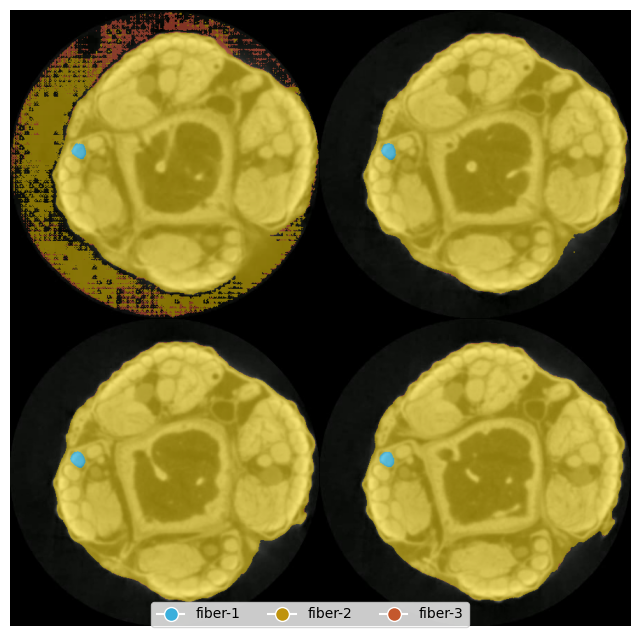

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

image_arrays = [
    frame_sample[0],
    frame_sample[3],
    frame_sample[6],
    frame_sample[9]
]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

plt.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(axes.flat):
    if i < len(image_arrays):
        img_array = image_arrays[i]
        image_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        ax.imshow(image_rgb, origin='upper', aspect='auto')
        ax.axis('off')

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='fiber-1', markerfacecolor='#3aafdc', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='fiber-2', markerfacecolor='#bf930d', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='fiber-3', markerfacecolor='#c4582d', markersize=10),
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.1), bbox_transform=fig.transFigure)

plt.savefig('/content/track-fly.png', bbox_inches='tight', pad_inches=0.01)
plt.show()


In [ ]:
target_0, target_1, target_2 = [], [], []
for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
    print(frame_idx, object_ids)
    masks = (mask_logits > 0.0).cpu().numpy()
    masks = np.squeeze(masks).astype(bool)

    detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )
    target_0.append(detections.xyxy[0])
    target_1.append(detections.xyxy[1])
    target_2.append(detections.xyxy[2])

propagate in video:   0%|          | 0/100 [00:00<?, ?it/s]

0 [1, 2, 3]


propagate in video:   2%|▏         | 2/100 [00:01<00:59,  1.66it/s]

1 [1, 2, 3]


propagate in video:   3%|▎         | 3/100 [00:02<01:23,  1.17it/s]

2 [1, 2, 3]


propagate in video:   4%|▍         | 4/100 [00:03<01:38,  1.02s/it]

3 [1, 2, 3]


propagate in video:   5%|▌         | 5/100 [00:05<01:48,  1.14s/it]

4 [1, 2, 3]
5 [1, 2, 3]


propagate in video:   6%|▌         | 6/100 [00:06<01:57,  1.25s/it]

6 [1, 2, 3]


propagate in video:   7%|▋         | 7/100 [00:08<02:05,  1.35s/it]

7 [1, 2, 3]


propagate in video:   8%|▊         | 8/100 [00:09<02:12,  1.45s/it]

8 [1, 2, 3]


propagate in video:   9%|▉         | 9/100 [00:11<02:17,  1.51s/it]

9 [1, 2, 3]


propagate in video:  10%|█         | 10/100 [00:13<02:20,  1.56s/it]

10 [1, 2, 3]


propagate in video:  11%|█         | 11/100 [00:14<02:21,  1.59s/it]

11 [1, 2, 3]


propagate in video:  12%|█▏        | 12/100 [00:16<02:22,  1.62s/it]

12 [1, 2, 3]


propagate in video:  13%|█▎        | 13/100 [00:18<02:22,  1.64s/it]

13 [1, 2, 3]


propagate in video:  14%|█▍        | 14/100 [00:19<02:22,  1.66s/it]

14 [1, 2, 3]


propagate in video:  15%|█▌        | 15/100 [00:21<02:21,  1.67s/it]

15 [1, 2, 3]


propagate in video:  16%|█▌        | 16/100 [00:23<02:21,  1.68s/it]

16 [1, 2, 3]


propagate in video:  17%|█▋        | 17/100 [00:24<02:19,  1.69s/it]

17 [1, 2, 3]


propagate in video:  18%|█▊        | 18/100 [00:26<02:18,  1.69s/it]

18 [1, 2, 3]


propagate in video:  19%|█▉        | 19/100 [00:28<02:17,  1.69s/it]

19 [1, 2, 3]


propagate in video:  20%|██        | 20/100 [00:30<02:15,  1.69s/it]

20 [1, 2, 3]


propagate in video:  21%|██        | 21/100 [00:31<02:13,  1.70s/it]

21 [1, 2, 3]


propagate in video:  22%|██▏       | 22/100 [00:33<02:12,  1.70s/it]

22 [1, 2, 3]


propagate in video:  23%|██▎       | 23/100 [00:35<02:10,  1.70s/it]

23 [1, 2, 3]


propagate in video:  24%|██▍       | 24/100 [00:36<02:08,  1.70s/it]

24 [1, 2, 3]


propagate in video:  25%|██▌       | 25/100 [00:38<02:07,  1.70s/it]

25 [1, 2, 3]


propagate in video:  26%|██▌       | 26/100 [00:40<02:05,  1.70s/it]

26 [1, 2, 3]


propagate in video:  27%|██▋       | 27/100 [00:41<02:03,  1.69s/it]

27 [1, 2, 3]


propagate in video:  28%|██▊       | 28/100 [00:43<02:01,  1.69s/it]

28 [1, 2, 3]


propagate in video:  29%|██▉       | 29/100 [00:45<01:59,  1.68s/it]

29 [1, 2, 3]


propagate in video:  30%|███       | 30/100 [00:46<01:57,  1.68s/it]

30 [1, 2, 3]


propagate in video:  31%|███       | 31/100 [00:48<01:55,  1.67s/it]

31 [1, 2, 3]


propagate in video:  32%|███▏      | 32/100 [00:50<01:53,  1.67s/it]

32 [1, 2, 3]


propagate in video:  33%|███▎      | 33/100 [00:51<01:51,  1.67s/it]

33 [1, 2, 3]


propagate in video:  34%|███▍      | 34/100 [00:53<01:49,  1.66s/it]

34 [1, 2, 3]


propagate in video:  35%|███▌      | 35/100 [00:55<01:48,  1.66s/it]

35 [1, 2, 3]


propagate in video:  36%|███▌      | 36/100 [00:56<01:46,  1.66s/it]

36 [1, 2, 3]


propagate in video:  37%|███▋      | 37/100 [00:58<01:44,  1.66s/it]

37 [1, 2, 3]


propagate in video:  38%|███▊      | 38/100 [01:00<01:42,  1.65s/it]

38 [1, 2, 3]


propagate in video:  39%|███▉      | 39/100 [01:01<01:40,  1.65s/it]

39 [1, 2, 3]


propagate in video:  40%|████      | 40/100 [01:03<01:38,  1.64s/it]

40 [1, 2, 3]


propagate in video:  41%|████      | 41/100 [01:05<01:36,  1.64s/it]

41 [1, 2, 3]


propagate in video:  42%|████▏     | 42/100 [01:06<01:35,  1.64s/it]

42 [1, 2, 3]


propagate in video:  43%|████▎     | 43/100 [01:08<01:33,  1.64s/it]

43 [1, 2, 3]


propagate in video:  44%|████▍     | 44/100 [01:09<01:31,  1.64s/it]

44 [1, 2, 3]


propagate in video:  45%|████▌     | 45/100 [01:11<01:29,  1.64s/it]

45 [1, 2, 3]


propagate in video:  46%|████▌     | 46/100 [01:13<01:28,  1.63s/it]

46 [1, 2, 3]


propagate in video:  47%|████▋     | 47/100 [01:14<01:26,  1.63s/it]

47 [1, 2, 3]


propagate in video:  48%|████▊     | 48/100 [01:16<01:24,  1.63s/it]

48 [1, 2, 3]


propagate in video:  49%|████▉     | 49/100 [01:18<01:23,  1.63s/it]

49 [1, 2, 3]


propagate in video:  50%|█████     | 50/100 [01:19<01:21,  1.63s/it]

50 [1, 2, 3]


propagate in video:  51%|█████     | 51/100 [01:21<01:19,  1.63s/it]

51 [1, 2, 3]


propagate in video:  52%|█████▏    | 52/100 [01:22<01:18,  1.63s/it]

52 [1, 2, 3]


propagate in video:  53%|█████▎    | 53/100 [01:24<01:16,  1.63s/it]

53 [1, 2, 3]


propagate in video:  54%|█████▍    | 54/100 [01:26<01:15,  1.63s/it]

54 [1, 2, 3]


propagate in video:  55%|█████▌    | 55/100 [01:27<01:13,  1.63s/it]

55 [1, 2, 3]


propagate in video:  56%|█████▌    | 56/100 [01:29<01:11,  1.63s/it]

56 [1, 2, 3]


propagate in video:  57%|█████▋    | 57/100 [01:31<01:10,  1.63s/it]

57 [1, 2, 3]


propagate in video:  58%|█████▊    | 58/100 [01:32<01:08,  1.64s/it]

58 [1, 2, 3]


propagate in video:  59%|█████▉    | 59/100 [01:34<01:07,  1.64s/it]

59 [1, 2, 3]


propagate in video:  60%|██████    | 60/100 [01:36<01:05,  1.64s/it]

60 [1, 2, 3]


propagate in video:  61%|██████    | 61/100 [01:37<01:03,  1.64s/it]

61 [1, 2, 3]


propagate in video:  62%|██████▏   | 62/100 [01:39<01:02,  1.64s/it]

62 [1, 2, 3]


propagate in video:  63%|██████▎   | 63/100 [01:41<01:00,  1.65s/it]

63 [1, 2, 3]


propagate in video:  64%|██████▍   | 64/100 [01:42<00:59,  1.65s/it]

64 [1, 2, 3]


propagate in video:  65%|██████▌   | 65/100 [01:44<00:57,  1.65s/it]

65 [1, 2, 3]


propagate in video:  66%|██████▌   | 66/100 [01:46<00:56,  1.65s/it]

66 [1, 2, 3]


propagate in video:  67%|██████▋   | 67/100 [01:47<00:54,  1.65s/it]

67 [1, 2, 3]


propagate in video:  68%|██████▊   | 68/100 [01:49<00:52,  1.66s/it]

68 [1, 2, 3]


propagate in video:  69%|██████▉   | 69/100 [01:50<00:51,  1.66s/it]

69 [1, 2, 3]


propagate in video:  70%|███████   | 70/100 [01:52<00:49,  1.66s/it]

70 [1, 2, 3]


propagate in video:  71%|███████   | 71/100 [01:54<00:48,  1.66s/it]

71 [1, 2, 3]


propagate in video:  72%|███████▏  | 72/100 [01:55<00:46,  1.66s/it]

72 [1, 2, 3]


propagate in video:  73%|███████▎  | 73/100 [01:57<00:44,  1.66s/it]

73 [1, 2, 3]


propagate in video:  74%|███████▍  | 74/100 [01:59<00:43,  1.66s/it]

74 [1, 2, 3]


propagate in video:  75%|███████▌  | 75/100 [02:00<00:41,  1.66s/it]

75 [1, 2, 3]


propagate in video:  76%|███████▌  | 76/100 [02:02<00:39,  1.66s/it]

76 [1, 2, 3]


propagate in video:  77%|███████▋  | 77/100 [02:04<00:38,  1.66s/it]

77 [1, 2, 3]


propagate in video:  78%|███████▊  | 78/100 [02:05<00:36,  1.66s/it]

78 [1, 2, 3]


propagate in video:  79%|███████▉  | 79/100 [02:07<00:34,  1.66s/it]

79 [1, 2, 3]


propagate in video:  80%|████████  | 80/100 [02:09<00:33,  1.66s/it]

80 [1, 2, 3]


propagate in video:  81%|████████  | 81/100 [02:10<00:31,  1.66s/it]

81 [1, 2, 3]


propagate in video:  82%|████████▏ | 82/100 [02:12<00:29,  1.66s/it]

82 [1, 2, 3]


propagate in video:  83%|████████▎ | 83/100 [02:14<00:28,  1.66s/it]

83 [1, 2, 3]


propagate in video:  84%|████████▍ | 84/100 [02:15<00:26,  1.66s/it]

84 [1, 2, 3]


propagate in video:  85%|████████▌ | 85/100 [02:17<00:24,  1.66s/it]

85 [1, 2, 3]


propagate in video:  86%|████████▌ | 86/100 [02:19<00:23,  1.66s/it]

86 [1, 2, 3]


propagate in video:  87%|████████▋ | 87/100 [02:20<00:21,  1.66s/it]

87 [1, 2, 3]


propagate in video:  88%|████████▊ | 88/100 [02:22<00:19,  1.66s/it]

88 [1, 2, 3]


propagate in video:  89%|████████▉ | 89/100 [02:24<00:18,  1.66s/it]

89 [1, 2, 3]


propagate in video:  90%|█████████ | 90/100 [02:25<00:16,  1.66s/it]

90 [1, 2, 3]


propagate in video:  91%|█████████ | 91/100 [02:27<00:14,  1.66s/it]

91 [1, 2, 3]


propagate in video:  92%|█████████▏| 92/100 [02:29<00:13,  1.66s/it]

92 [1, 2, 3]


propagate in video:  93%|█████████▎| 93/100 [02:30<00:11,  1.66s/it]

93 [1, 2, 3]


propagate in video:  94%|█████████▍| 94/100 [02:32<00:09,  1.66s/it]

94 [1, 2, 3]


propagate in video:  95%|█████████▌| 95/100 [02:34<00:08,  1.66s/it]

95 [1, 2, 3]


propagate in video:  96%|█████████▌| 96/100 [02:35<00:06,  1.66s/it]

96 [1, 2, 3]


propagate in video:  97%|█████████▋| 97/100 [02:37<00:04,  1.66s/it]

97 [1, 2, 3]


propagate in video:  98%|█████████▊| 98/100 [02:39<00:03,  1.65s/it]

98 [1, 2, 3]


propagate in video:  99%|█████████▉| 99/100 [02:40<00:01,  1.65s/it]

99 [1, 2, 3]


propagate in video: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


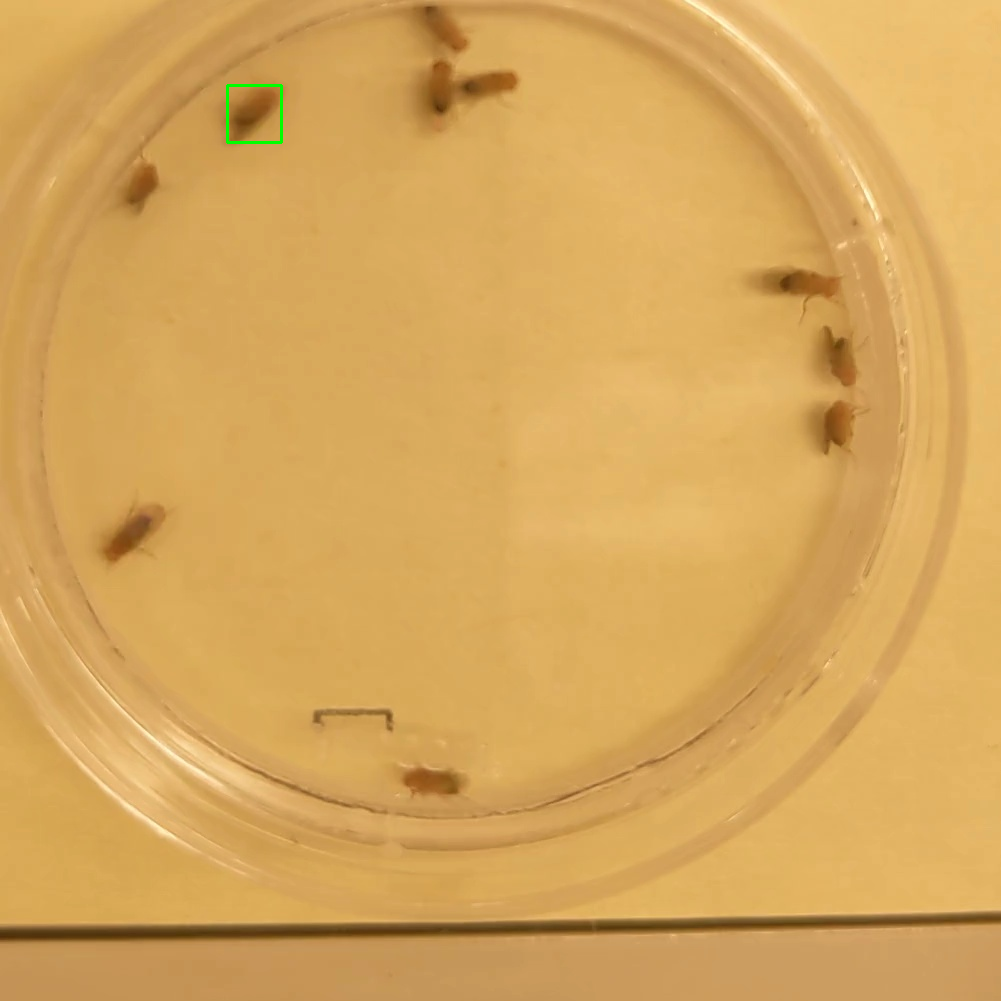

In [ ]:
from google.colab.patches import cv2_imshow

frame = cv2.imread('/content/injured_1/00000.jpeg')

if frame is not None and len(target_0) > 0:
    x1, y1, x2, y2 = target_0[0].astype(int)
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) # Draw green rectangle
    cv2_imshow(frame)  # Display the frame
else:
    print("Error: Could not read frame or target_0 is empty.")


In [ ]:
center_target_0 = [(int((target_0_i[0] + target_0_i[2]) / 2), int((target_0_i[1] + target_0_i[3]) / 2)) for target_0_i in target_0]
center_target_1 = [(int((target_1_i[0] + target_1_i[2]) / 2), int((target_1_i[1] + target_1_i[3]) / 2)) for target_1_i in target_1]
center_target_2 = [(int((target_2_i[0] + target_2_i[2]) / 2), int((target_2_i[1] + target_2_i[3]) / 2)) for target_2_i in target_2]

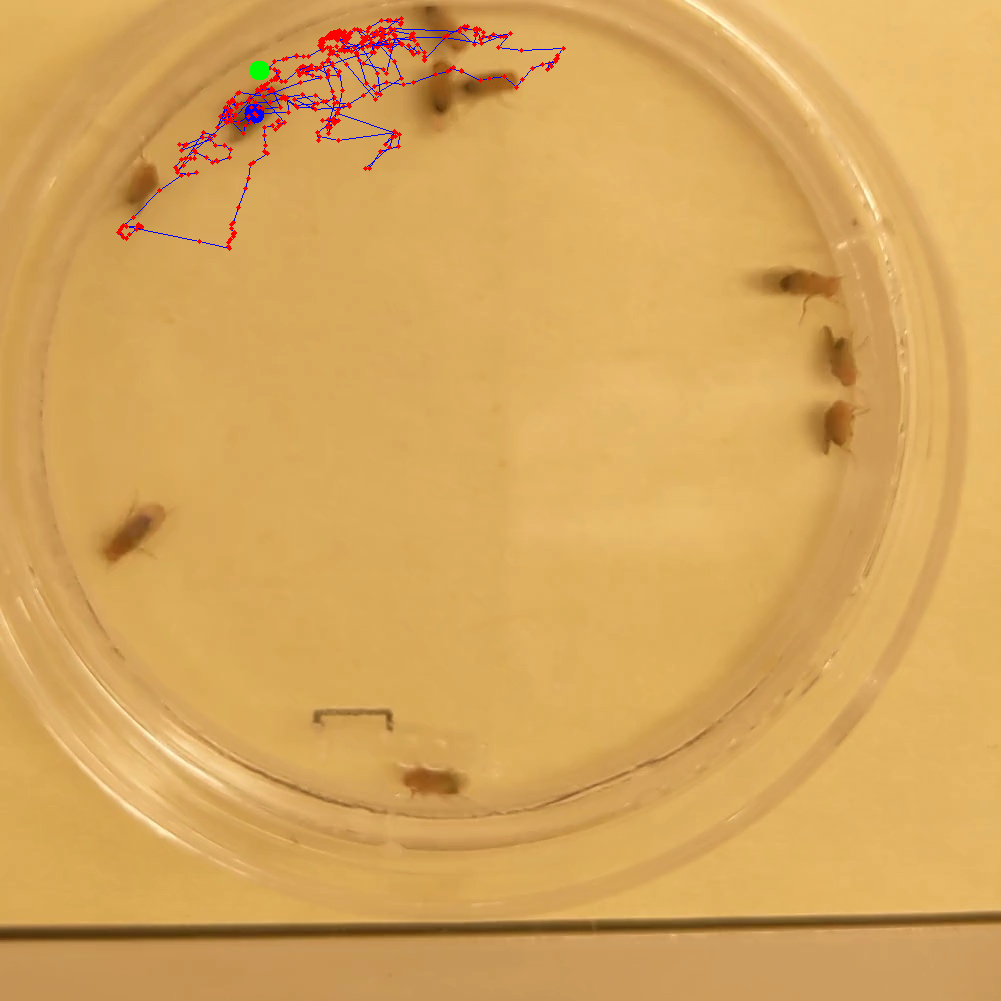

In [ ]:
# Sample sequence of locations (x, y)
locations = center_target_0

background_image = cv2.imread('/content/injured_1/00000.jpeg')

cv2.circle(background_image, locations[0], radius=10, color=(255, 0, 0), thickness=-1)

for i in range(len(locations) - 1):
    start_point = locations[i]
    end_point = locations[i + 1]
    cv2.line(background_image, start_point, end_point, (255, 0, 0), thickness=1)  # Blue line
    cv2.circle(background_image, start_point, radius=2, color=(0, 0, 255), thickness=-1)  # Red circle at points

cv2.circle(background_image, locations[-1], radius=10, color=(0, 255, 0), thickness=-1)

cv2_imshow(background_image)


# Save the result if needed
# cv2.imwrite("trace_of_movement.png", background_image)